<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/Transformer_Seq10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index", "Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)
data['Time_diff'] = data['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data['Latitude'].diff().fillna(0)
data['Lon_diff'] = data['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + 1e-5)
data.fillna(method='ffill', inplace=True)
scaler = MinMaxScaler()
numeric_columns = ['Latitude', 'Longitude']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [3]:
def create_sequences(data, n_input=100, n_output=10):
    X, y = [], []
    for i in range(n_input, len(data) - n_output + 1):
        X.append(data.iloc[i-n_input:i][numeric_columns].values)
        y.append(data.iloc[i:i+n_output][['Latitude', 'Longitude']].values.flatten())
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = create_sequences(data)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [5]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, device='cuda'):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() * -(np.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1)]


# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_dim, max_seq_length, device):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length, device=device)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, batch_first=True)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = self.fc_out(output[:, -1, :])
        return output



In [6]:
# Hyperparameters and model initialization
input_dim = 2
d_model = 128
nhead = 4
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 128
output_dim = 20  # Adjust based on your output sequence length and dimensions
max_seq_length = 100

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, output_dim, max_seq_length, device = device).to(device)


Epoch 1: Train Loss: 0.0016, Validation Loss: 0.0002
Epoch 2: Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 3: Train Loss: 0.0003, Validation Loss: 0.0002
Epoch 4: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 5: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 6: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 7: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 8: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 9: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 10: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 11: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 12: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 13: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 14: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 15: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 16: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 17: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 18: Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 19: Train Loss: 0.0002, Validat

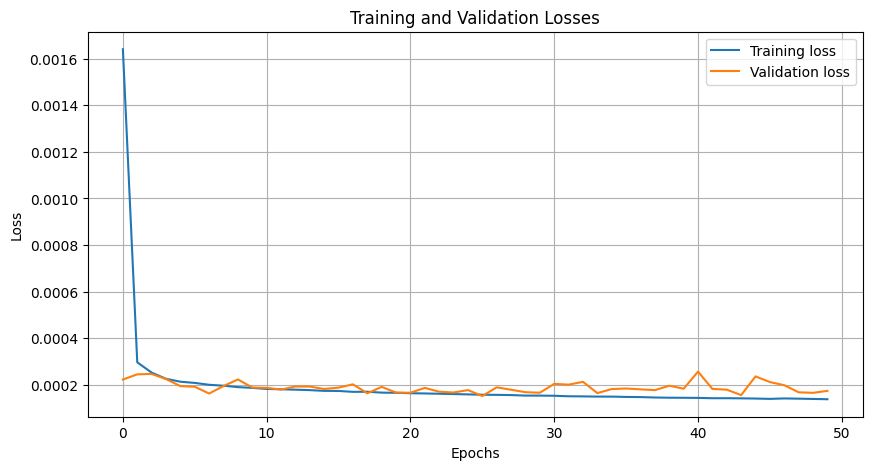

In [7]:
import matplotlib.pyplot as plt

# Modified training and validation function to record losses
def train_and_validate(model, train_loader, val_loader, num_epochs, device):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        if avg_val_loss < best_val_loss:
            torch.save(model.state_dict(), 'best_model.pth')
            best_val_loss = avg_val_loss

    return train_losses, val_losses

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Training the model
train_losses, val_losses = train_and_validate(model, train_loader, test_loader, num_epochs=50, device=device)

# Plotting the losses
plot_losses(train_losses, val_losses)


In [10]:
import numpy as np
from sklearn.metrics import mean_squared_error

def evaluate_model(model, test_loader, device, scaler):
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)
    model.eval()

    all_past_data = []
    all_predictions = []
    all_actuals = []
    rmses = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            predictions = predictions.view(-1, 10, 2).cpu().numpy()
            actuals = y_batch.view(-1, 10, 2).cpu().numpy()
            past_data = X_batch[:, -100:, :2].view(-1, 100, 2).cpu().numpy()  # Assuming the last 100 points are relevant

            # Inverse transform to original scale
            predictions = scaler.inverse_transform(predictions.reshape(-1, 2)).reshape(-1, 10, 2)
            actuals = scaler.inverse_transform(actuals.reshape(-1, 2)).reshape(-1, 10, 2)
            past_data = scaler.inverse_transform(past_data.reshape(-1, 2)).reshape(-1, 100, 2)

            all_past_data.append(past_data)
            all_predictions.append(predictions)
            all_actuals.append(actuals)

            # Calculate RMSE for this batch and append
            batch_rmse = np.sqrt(mean_squared_error(predictions.reshape(-1, 2), actuals.reshape(-1, 2)))
            rmses.append(batch_rmse)

    average_rmse = np.mean(rmses)
    return all_past_data, all_actuals, all_predictions, rmses, average_rmse

# Example usage
all_past_data, all_actuals, all_predictions, rmses, average_rmse = evaluate_model(model, test_loader, device='cuda', scaler=scaler)
print("Average RMSE:", average_rmse)


Average RMSE: 0.015042647


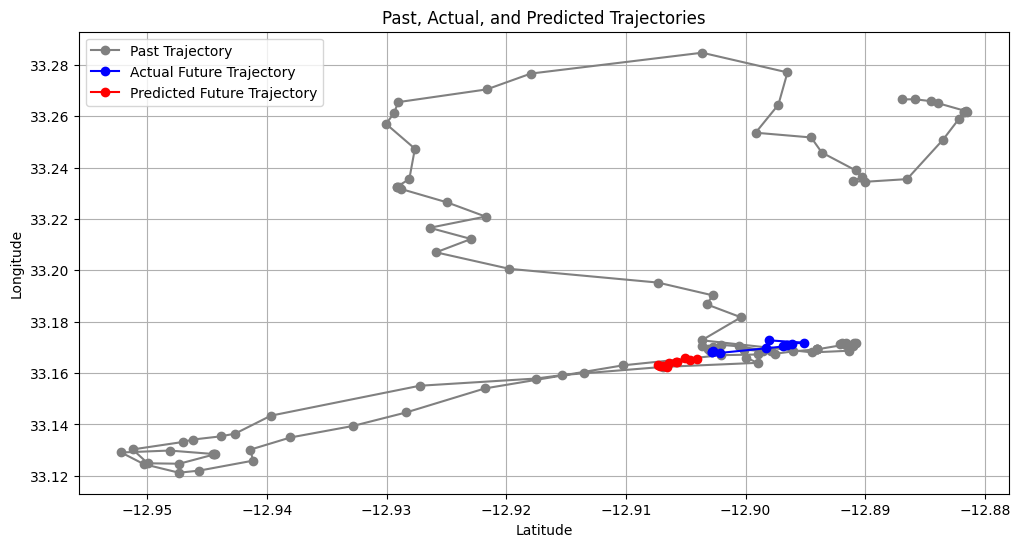

In [11]:
def plot_trajectories(past_data, actuals, predictions, index=0):
    plt.figure(figsize=(12, 6))
    # Plot the past trajectory
    plt.plot(past_data[index][0][:, 0], past_data[index][0][:, 1], 'gray', label='Past Trajectory', marker='o')
    # Plot the actual future trajectory
    plt.plot(actuals[index][0][:, 0], actuals[index][0][:, 1], 'bo-', label='Actual Future Trajectory')
    # Plot the predicted future trajectory
    plt.plot(predictions[index][0][:, 0], predictions[index][0][:, 1], 'ro-', label='Predicted Future Trajectory')

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Past, Actual, and Predicted Trajectories')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectories(all_past_data, all_actuals, all_predictions, index=0)
